In [1]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import tifffile
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom

In [16]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'dcis')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [9]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/config.yaml$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/co

In [11]:
case_to_sections = {fp.split('/')[-3]:yaml.safe_load(open(fp))['sections'] for fp in fps}
case_to_sections.keys()

dict_keys(['C3L-00970', 'C3L-00982', 'C3L-01287', 'C3L-02551', 'HT206B1', 'HT225C1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT413C1-K2', 'HT413C1-Th1k4A1', 'HT448C1-Th1K1Fp1', 'HT553P1-H2', 'HT565B1-H2', 'S18-25943-A7', 'S18-5591-C8', 'S18-9906', 'P21_F2RM6R'])

In [13]:
case = 'HT206B1'
sections = case_to_sections[case]
sections

[{'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s0_HT206B1-U1_xenium.h5ad'}],
  'position': 0,
  'sid': 'HT206B1-U1'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s1_HT206B1-U2_multiplex.ome.tiff'}],
  'position': 5,
  'sid': 'HT206B1-U2'},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s2_HT206B1-U4_he.tif'}],
  'position': 15,
  'sid': 'HT206B1-U4'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s3_HT206B1-U5_multiplex.ome.tiff'}],
  'position': 20,
  'sid': 'HT206B1-U5'},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s4_HT206B1-U8_xenium.h5ad'}],
  'position': 40,
  'sid': 'HT206B1-U8'},
 {'data': [{'dtype': 'xenium',
    'filep

In [14]:
dtype_to_volume = pickle.load(
    open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
)['labeled'] 

outputs = pickle.load(
    open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
)
section_ids = outputs['section_ids']
section_positions = outputs['section_positions']
section_ids, section_positions

([('HT206B1-U1', 'xenium'),
  ('HT206B1-U2', 'multiplex'),
  ('HT206B1-U4', 'he'),
  ('HT206B1-U5', 'multiplex'),
  ('HT206B1-U8', 'xenium'),
  ('HT206B1-U9', 'xenium'),
  ('HT206B1-U10', 'multiplex'),
  ('HT206B1-U12', 'he'),
  ('HT206B1-U13', 'multiplex'),
  ('HT206B1-U16', 'xenium'),
  ('HT206B1-U17', 'xenium'),
  ('HT206B1-U18', 'multiplex'),
  ('HT206B1-U20', 'he'),
  ('HT206B1-U21', 'multiplex'),
  ('HT206B1-U24', 'xenium')],
 array([ 0,  1,  3,  4,  8,  9, 10, 12, 13, 16, 17, 18, 20, 21, 24]))

In [18]:
volume = outputs['dtype_to_volume']['integrated']
volume.shape

(25, 132, 124)

In [15]:
mushroom = Mushroom.from_config(
    os.path.join(project_dir, case, 'mushroom_50res'), accelerator='cpu'
)

INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:3 sections detected: ['HT206B1-U4', 'HT206B1-U12', 'HT206B1-U20']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U4


0.02


INFO:root:generating image data for section HT206B1-U12
INFO:root:generating image data for section HT206B1-U20
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('HT206B1-U4', 'he'), ('HT206B1-U12', 'he'), ('HT206B1-U20', 'he')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpy1bu5juk
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpy1bu5juk/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized


he torch.Size([3, 130, 121])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/he_chkpts/last-v3.ckpt
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 36 channels
INFO:root:6 sections detected: ['HT206B1-U2', 'HT206B1-U5', 'HT206B1-U10', 'HT206B1-U13', 'HT206B1-U18', 'HT206B1-U21']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U2


0.02


INFO:root:generating image data for section HT206B1-U5
INFO:root:generating image data for section HT206B1-U10
INFO:root:generating image data for section HT206B1-U13
INFO:root:generating image data for section HT206B1-U18
INFO:root:generating image data for section HT206B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT206B1-U2', 'multiplex'), ('HT206B1-U5', 'multiplex'), ('HT206B1-U10', 'multiplex'), ('HT206B1-U13', 'multiplex'), ('HT206B1-U18', 'multiplex'), ('HT206B1-U21', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

multiplex torch.Size([36, 130, 121])


INFO:root:using 377 channels
INFO:root:6 sections detected: ['HT206B1-U1', 'HT206B1-U8', 'HT206B1-U9', 'HT206B1-U16', 'HT206B1-U17', 'HT206B1-U24']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U1


50 grid (115764, 377)
(115764, 2)
[6042 6522]


INFO:root:generating image data for section HT206B1-U8


50 grid (116672, 377)
(116672, 2)
[5795 6401]


INFO:root:generating image data for section HT206B1-U9


50 grid (115808, 377)
(115808, 2)
[5908 6327]


INFO:root:generating image data for section HT206B1-U16


50 grid (117641, 377)
(117641, 2)
[5923 6143]


INFO:root:generating image data for section HT206B1-U17


50 grid (110489, 377)
(110489, 2)
[5712 6525]


INFO:root:generating image data for section HT206B1-U24


50 grid (119849, 377)
(119849, 2)
[5830 6418]
xenium torch.Size([377, 131, 122])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT206B1-U1', 'xenium'), ('HT206B1-U8', 'xenium'), ('HT206B1-U9', 'xenium'), ('HT206B1-U16', 'xenium'), ('HT206B1-U17', 'xenium'), ('HT206B1-U24', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/xenium_chkpts/last-v3.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch

Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

In [17]:
out_dir = os.path.join(output_dir, case)

In [19]:
obj = sc.read_h5ad(
    os.path.join(project_dir, case, 'xenium_cell_typing', 'cell_typing_obj.h5ad')
)
obj

AnnData object with n_obs × n_vars = 681554 × 377
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sid', 'n_counts', 'leiden', 'cell_type', 'cell_type_specific'
    var: 'n_cells'
    uns: 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [23]:
dtype = 'xenium'

In [29]:
fps = sorted(utils.listfiles(os.path.join(project_dir, case, 'registered')))
sid_to_adata = {
    re.sub(r'^.*/s[0-9]+_(.*)_xenium.h5ad', r'\1', fp): xenium.adata_from_xenium(fp)
    for fp in fps
    if 'xenium' in fp
}
sid_to_adata.keys()

dict_keys(['HT206B1-U1', 'HT206B1-U17', 'HT206B1-U24', 'HT206B1-U8', 'HT206B1-U9', 'HT206B1-U16'])

In [30]:
for sid, a in sid_to_adata.items():
    print(sid, a.shape)

HT206B1-U1 (115764, 477)
HT206B1-U17 (110489, 477)
HT206B1-U24 (119849, 377)
HT206B1-U8 (116672, 377)
HT206B1-U9 (115808, 477)
HT206B1-U16 (117641, 377)


In [31]:
keep = ['HT206B1-U1', 'HT206B1-U9', 'HT206B1-U17']
sid_to_adata = {k:v for k, v in sid_to_adata.items() if k in keep}

In [40]:
a = next(iter(sid_to_adata.values()))
genes = a.var.index.to_list()
'MGP' in a.var.index

True

In [34]:
size = visium.get_fullres_size(a)
size

(6530, 6054)

In [36]:
tiling_size = int(mushroom.trainer_kwargs['target_resolution'] / mushroom.trainer_kwargs['input_resolution'])
tiling_size

50

In [33]:
def tile_img(adata, tiling_size, size):
    n_rows, n_cols = size[-2] // tiling_size + 1, size[-1] // tiling_size + 1

    pts = adata.obsm['spatial'][:, [1, 0]]

    img = np.zeros((n_rows, n_cols, adata.shape[1]))
    for r in range(n_rows):
        r1, r2 = r * tiling_size, (r + 1) * tiling_size
        row_mask = ((pts[:, 0] >= r1) & (pts[:, 0] < r2))
        row_adata, row_pts = adata[row_mask], pts[row_mask]
        for c in range(n_cols):
            c1, c2 = c * tiling_size, (c + 1) * tiling_size
            col_mask = ((row_pts[:, 1] >= c1) & (row_pts[:, 1] < c2))
            img[r, c] = row_adata[col_mask].X.sum(0)
    return img

In [37]:
sid_to_img = {
    k:tile_img(a, tiling_size, size) for k, a in sid_to_adata.items()
}

In [38]:
for sid, img in sid_to_img.items():
    sid_to_img[sid] = utils.rescale(img, size=(volume.shape[-2], volume.shape[-1]), dim_order='h w c', target_dtype=img.dtype)

HT206B1-U1


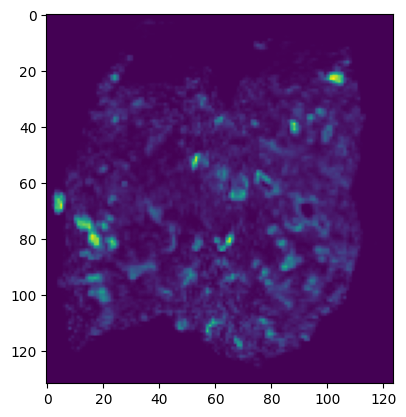

HT206B1-U17


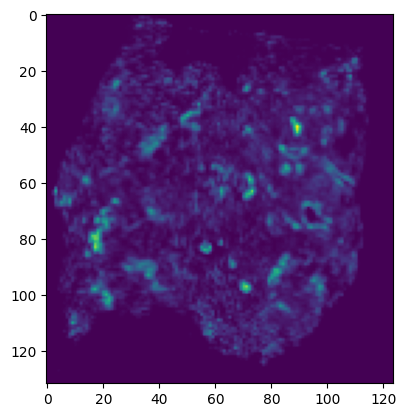

HT206B1-U9


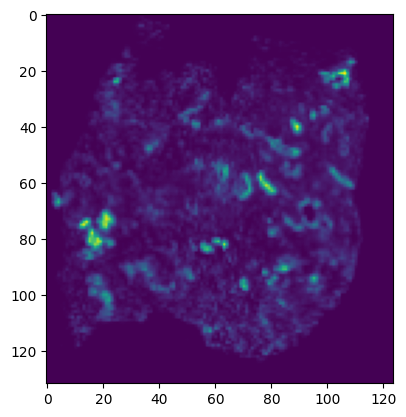

In [41]:
for sid, img in sid_to_img.items():
    print(sid)
    plt.imshow(img[..., genes.index('MGP')])
    plt.show()

In [44]:
order, positions = zip(*[(sid, pos)
                         for (sid, _), pos in zip(section_ids, section_positions)
                         if sid in keep])
order, positions

(('HT206B1-U1', 'HT206B1-U9', 'HT206B1-U17'), (0, 9, 17))

In [45]:
v = np.stack([sid_to_img[sid] for sid in order])
v = rearrange(v, 'n h w c -> c n h w')
v.shape

(477, 3, 132, 124)

In [46]:
positions = [*positions, mushroom.section_positions[-1]]
positions

[0, 9, 17, 24]

In [47]:
v = np.concatenate((
    v,
    v[:, -1:],
), axis=1)
interpolated = utils.get_interpolated_volume(v, positions, method='linear')
interpolated.shape

(477, 25, 132, 124)

In [51]:
Path(os.path.join(output_dir, case)).mkdir(parents=True, exist_ok=True)
tifffile.imwrite(os.path.join(output_dir, case, 'expression_volume.tif'), interpolated)

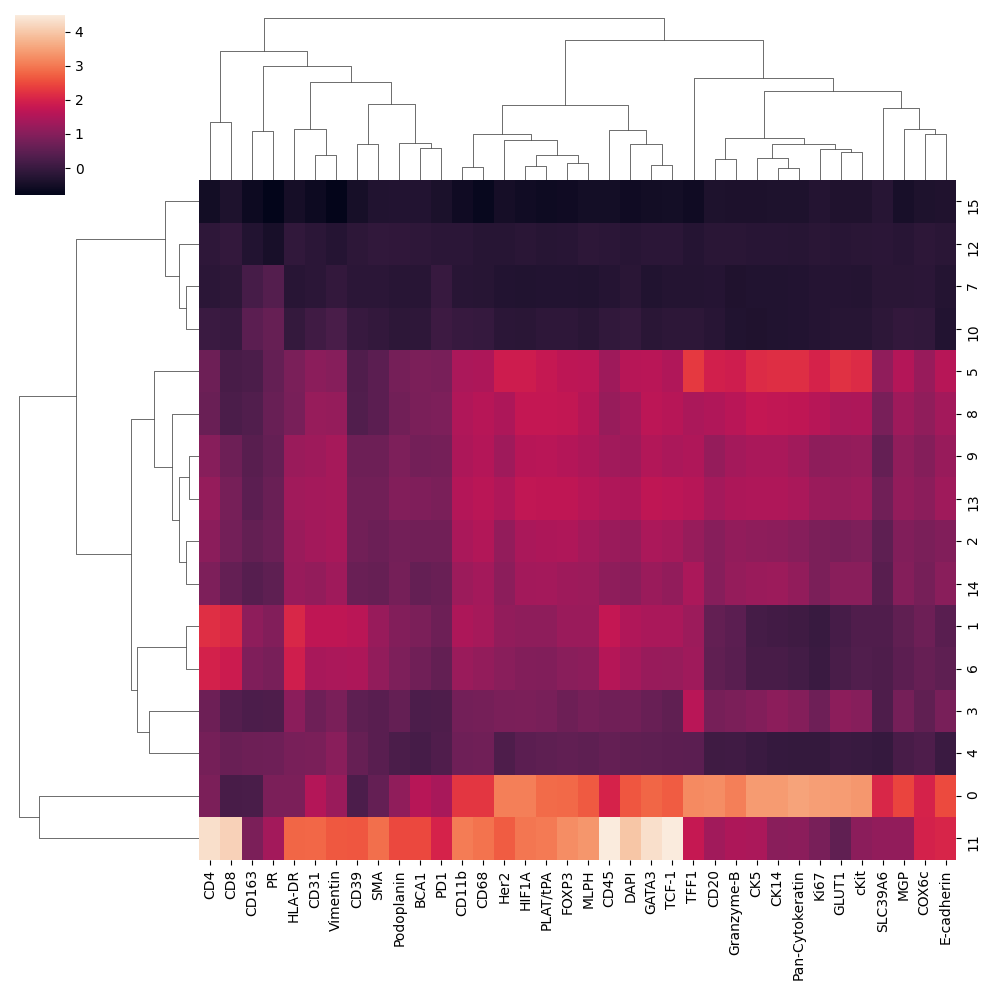

In [83]:
result = mushroom.calculate_cluster_intensities(projection_dtype='integrated')
sns.clustermap(result['multiplex'])

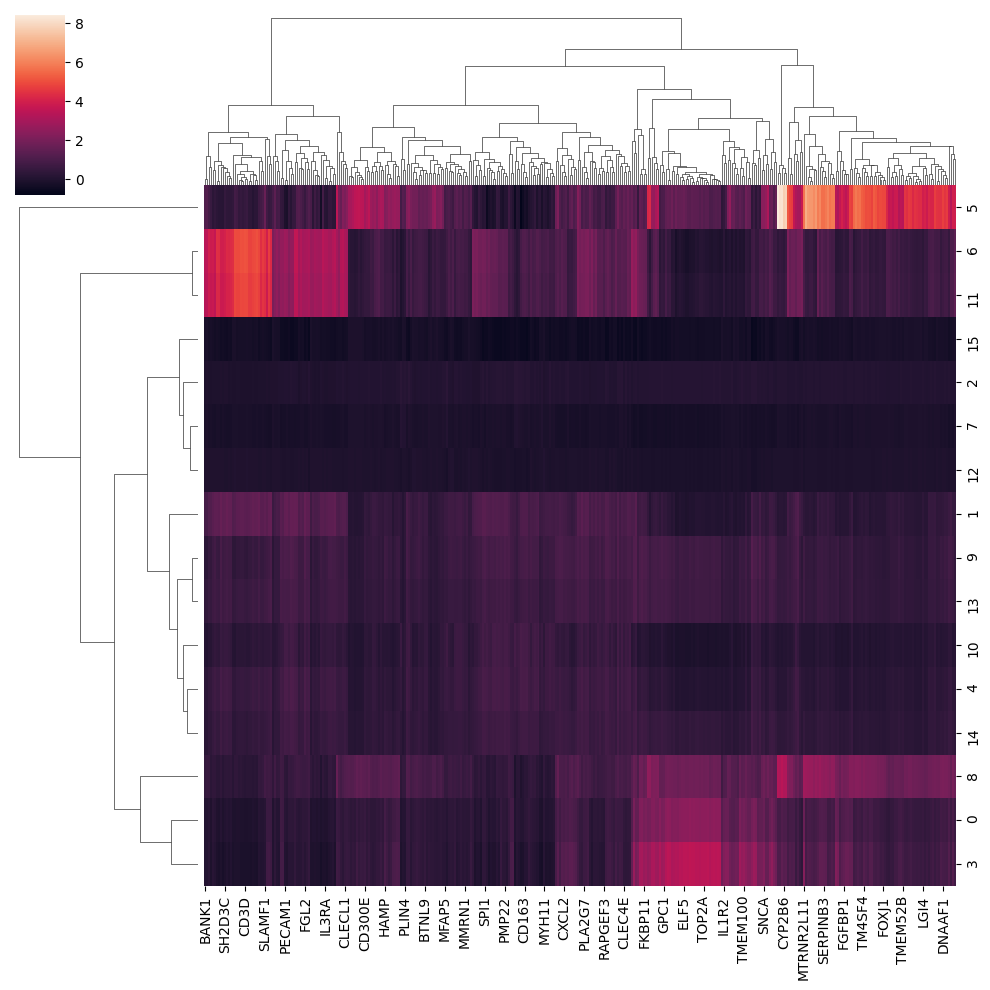

In [52]:
result = mushroom.calculate_cluster_intensities(projection_dtype='integrated')
sns.clustermap(result['xenium'])

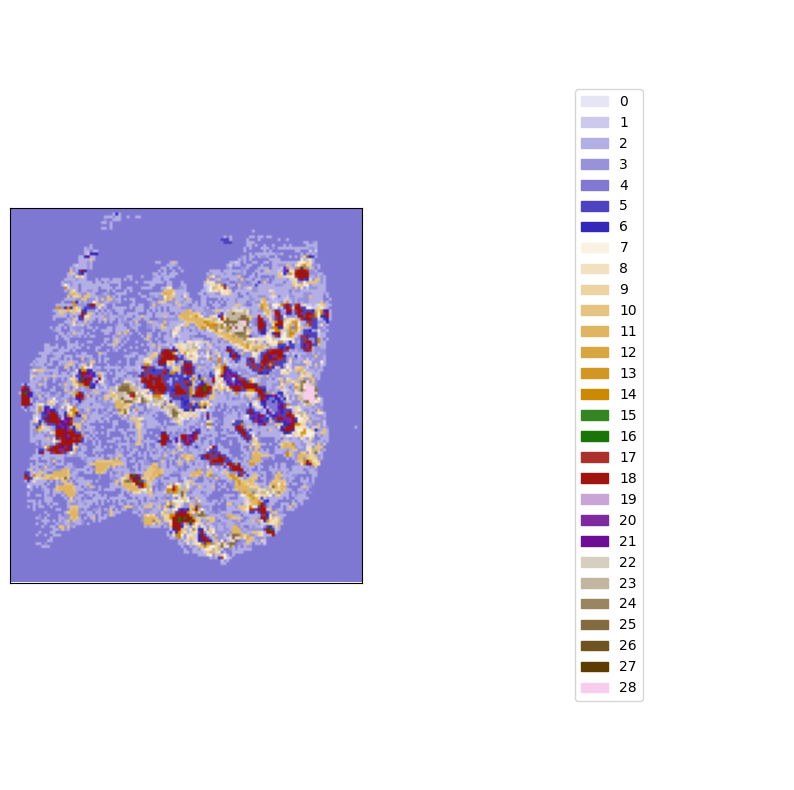

In [78]:
mushroom.display_clusters('xenium', section_idxs=[0], figsize=(10, 10))

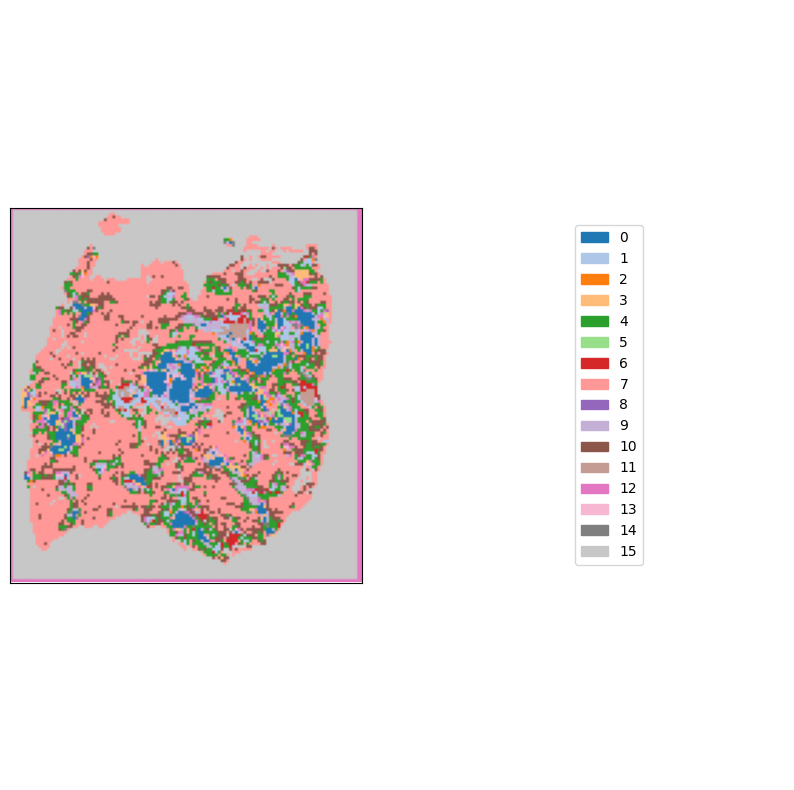

In [63]:
mushroom.display_clusters('integrated', section_idxs=[0], figsize=(10, 10))

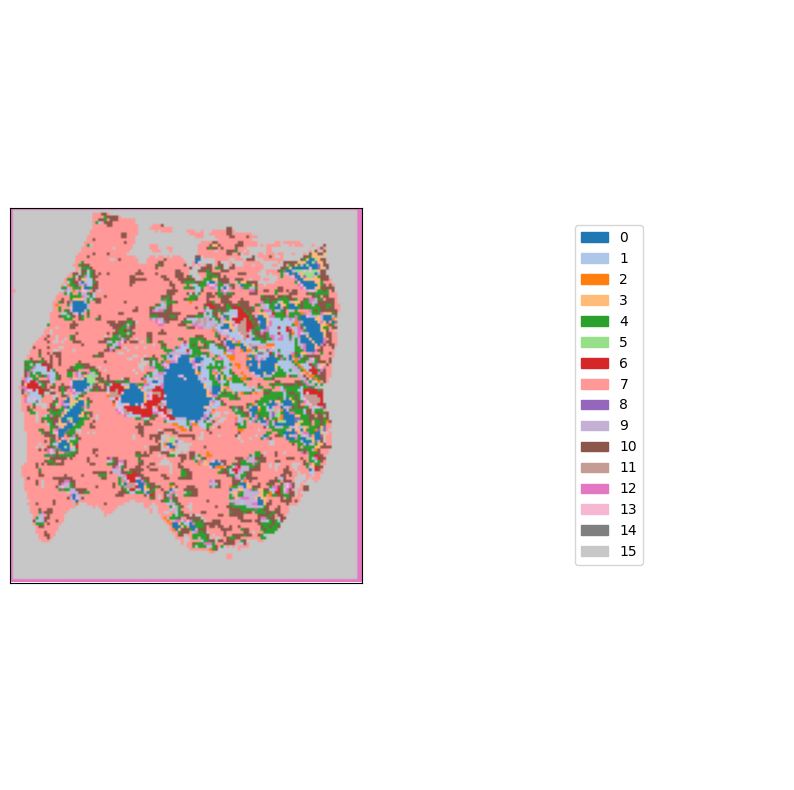

In [81]:
mushroom.display_clusters('integrated', section_idxs=[-1], figsize=(10, 10))

In [64]:
tumor_nbhds = [
    0, 3, 8
]

In [70]:
mask = np.zeros_like(volume)
for k in tumor_nbhds:
    mask[volume==k] = True
mask.shape

(25, 132, 124)

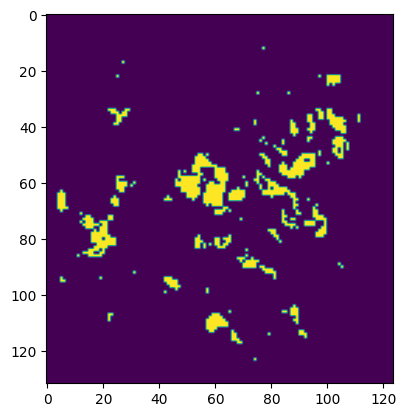

In [72]:
plt.imshow(mask[0])

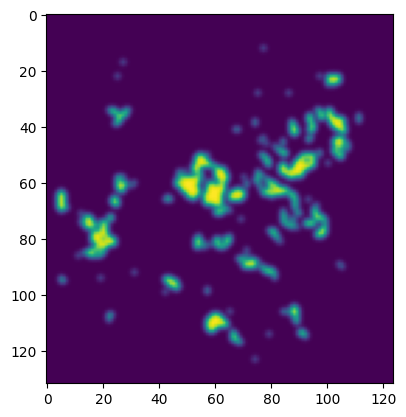

In [74]:
import scipy
mask = skimage.filters.gaussian(mask, sigma=1., channel_axis=0)
plt.imshow(mask[0])

In [76]:
tifffile.imwrite(os.path.join(output_dir, case, 'tumor_volume.tif'), mask)

In [77]:
genes.index('MGP')

298

In [80]:
genes.index('ACTA2')

4